In [6]:
# Import all the useful pacakges

In [2]:
from qiskit_nature.settings import settings
from qiskit_nature.drivers import UnitsType
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit.algorithms.optimizers import SLSQP, L_BFGS_B,POWELL,NELDER_MEAD
from qiskit.algorithms.optimizers import COBYLA, SLSQP,SPSA,CG
from qiskit import Aer
from qiskit.algorithms import VQE
settings.dict_aux_operators = True
from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.circuit.library import HartreeFock
from qiskit_nature.circuit.library import UCCSD
from qiskit_nature.settings import settings
from qiskit_nature.drivers import UnitsType
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit.circuit.library import TwoLocal



from qiskit.algorithms.minimum_eigensolvers import VQE  # new import!!!
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator
from qiskit_aer.primitives import Estimator as AerEstimator


In [ ]:
# You can get these data using Open fermion pacakages or you can use the pyscf package for the calculation
# H2_op = (-1.052373245772859 * I ^ I) + \
#         (0.39793742484318045 * I ^ Z) + \
#         (-0.39793742484318045 * Z ^ I) + \
#         (-0.01128010425623538 * Z ^ Z) + \
#         (0.18093119978423156 * X ^ X)

# print(f'Number of qubits: {H2_op.num_qubits}')

In [3]:

driver = PySCFDriver(atom='H .0 .0 0.0',
                     unit=UnitsType.ANGSTROM,
                     basis='631-g',
                
                     charge= -1,
                     spin = 0,
                     )
problem = driver.run()
problem = ElectronicStructureProblem(driver)
# generate the second-quantized operators
second_q_ops = problem.second_q_ops()
main_op = second_q_ops['ElectronicEnergy']
# You can get the number of particles and the spin orbitals involved in your calculation
num_particles = problem.num_particles
num_spin_orbitals = problem.num_spin_orbitals
print(num_particles)
print(num_spin_orbitals)

(1, 1)
4


In [4]:
 # You can change this according to your needs and type of calculation
# This is where you specify the simulator or device where you want to run your algorithm. 
backend = Aer.get_backend('qasm_simulator') 
# You can use the qubit converter according to your choice
from qiskit.algorithms import VQE
mapper = ParityMapper()
converter = QubitConverter(JordanWignerMapper())
#converter = QubitConverter(mapper=mapper, two_qubit_reduction=True) # While using the parity mapping

qubit_op = converter.convert(main_op, num_particles=num_particles)
#print(qubit_op)
print(f"qubit_op num_qubits={qubit_op.num_qubits}\n")


qubit_op num_qubits=4



In [5]:
properties = driver.run() # with this code you can get all the necessary informations about your code
num_alpha_electrons = properties.get_property('ParticleNumber').num_alpha
num_beta_electrons = properties.get_property('ParticleNumber').num_beta
num_spin_orbitals = int(properties.get_property('ParticleNumber').num_spin_orbitals)

nuclear_rep_energy = properties.get_property('ElectronicEnergy').nuclear_repulsion_energy
print("number of alpha electrons: " , num_alpha_electrons)
print("number of beta electrons: " , num_beta_electrons)
print("number of spin orbitals: " , num_spin_orbitals)
print("nuclear repulsion energy: " , nuclear_rep_energy)

In [ ]:
# If you want to specify the ansatz differently you can use this format
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

# Choose the ansatz
ansatz = "TwoLocal"

# Parameters for q-UCC antatze
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

# Put arguments for twolocal
if ansatz_type == "TwoLocal":
    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ['ry']
    # Entangling gates
    entanglement_blocks = 'cz'
    # How the qubits are entangled 
    entanglement = 'full'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 3
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = True
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "Custom":
    # Example of how to write your own circuit
    from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
    # Define the variational parameter
    theta = Parameter('a')
    n = qubit_op.num_qubits
    # Make an empty quantum circuit
    qc = QuantumCircuit(qubit_op.num_qubits)
    qubit_label = 0
    # Place a Hadamard gate
    qc.h(qubit_label)
    # Place a CNOT ladder
    for i in range(n-1):
        qc.cx(i, i+1)
    # Visual separator
    qc.barrier()
    # rz rotations on all qubits
    qc.rz(theta, range(n))
    ansatz = qc
    ansatz.compose(init_state, front=True, inplace=True)

print(ansatz)

In [6]:
# setup the initial state for the ansatz

#init_state = HartreeFock( problem.num_spin_orbitals, num_particles, converter)

#ansatz = TwoLocal(qubit_op.num_qubits, ['ry','rz'], 'cx','linear',initial_state = init_state,insert_barriers=True).decompose()
#ansatz = TwoLocal(qubit_op.num_qubits, ['ry','rz'], 'cx','linear')

init_state = HartreeFock( problem.num_spin_orbitals, num_particles, converter)


my_ansatz = UCCSD(qubit_converter = converter,
               num_particles = num_particles,
               num_spin_orbitals = problem.num_spin_orbitals,
               initial_state = init_state).decompose()



print('Number of Parameter= ',my_ansatz.num_parameters)
print('Depth = ',my_ansatz.depth())
print('Number of Qubits= ',qubit_op.num_qubits)
print("number of spin orbitals= " , num_spin_orbitals)
print('Number of Puli string= ',qubit_op.num_qubits)
#print(my_ansatz)
#my_ansatz.decompose().draw('mpl', style='iqx')

Number of Parameter=  3
Depth =  4
Number of Qubits=  4
number of spin orbitals=  4
Number of Puli string=  4


In [69]:
from qiskit.algorithms import VQE,NumPyMinimumEigensolver
#  The minimum eigensolver is only searching over 
#feasible states and returns an eigenstate that has the smallest eigenvalue among feasible states
npme = NumPyMinimumEigensolver()
result= npme.compute_minimum_eigenvalue(operator=qubit_op)
from qiskit import Aer
from qiskit_aer import AerSimulator
slsqp = SLSQP(maxiter=2000)
bfgs_optimizer = L_BFGS_B(maxiter=2000)
cobyla = COBYLA(maxiter=2000)
spsa= SPSA(maxiter=2000)
cg= CG(maxiter=2000)


# # backend = AerSimulator()
qi = QuantumInstance(backend=backend, shots=10000, seed_simulator=42)

# estimator = Estimator(options={"shots": 2048})
# vqe = VQE(estimator, my_ansatz, cg)
# result = vqe.compute_minimum_eigenvalue(qubit_op)

# # aer_estimator = AerEstimator(run_options={"shots": 2048, "seed": 42})
# # vqe = VQE(aer_estimator, my_ansatz, opt)

In [70]:
#The optimizer guides the evolution of the parameters of the ansatz so it is very important to investigate the energy convergence 
#as it would define the number of measurements that have to be performed on the QPU.
#A clever choice might reduce drastically the number of needed energy evaluations.
# If you want to use different ansatz you can follow this format
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

optimizer_type = 'SPSA'

# You may want to tune the parameters 
# of each optimizer, here the defaults are used
if optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=500)
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=500)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=500)
elif optimizer_type == 'SLSQP':
    optimizer = SLSQP(maxiter=500)

In [8]:

algorithm = VQE(my_ansatz,
                optimizer=slsqp,
                include_custom=True,
                quantum_instance=qi)

result_slsqp = algorithm.compute_minimum_eigenvalue(qubit_op)
print("VQE result =====")
print(result_slsqp)
print("\n==========\n\n")

electronic_structure_result_slsqp = problem.interpret(result_slsqp)
print(electronic_structure_result_slsqp)




# vqe = VQE(my_ansatz, optimizer=slsqp, quantum_instance=qi)
# result = vqe.compute_minimum_eigenvalue(qubit_op)
 
# print(result.eigenvalue)

/tmp/ipykernel_143024/928342979.py:1: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  algorithm = VQE(ansatz,


VQE result =====
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 34,
    'eigenstate': {   '0101': 0.9980480950335009,
                      '1001': 0.01,
                      '1010': 0.061644140029689765},
    'eigenvalue': (-0.43137768535492865+0j),
    'optimal_circuit': None,
    'optimal_parameters': {   ParameterVectorElement(t[0]): 1.5768880184542653,
                              ParameterVectorElement(t[1]): 1.5771087601359912,
                              ParameterVectorElement(t[2]): 1.6363817916433332},
    'optimal_point': array([1.57688802, 1.57710876, 1.63638179]),
    'optimal_value': -0.43137768535492865,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': 0.2496657371520996}



=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -0.431377685355
  - computed part:      -0.431377685355
~ Nuclear repulsion energy (Hartree): 0.0
> Total ground state energy (Hartree): -0.431377685355
 
=== MEASURED OBSER

In [29]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=qubit_op)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.16f}')

Reference value: -0.4982329107290711


/tmp/ipykernel_143024/4039322974.py:1: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.numpy_minimum_eigen_solver.NumPyMinimumEigensolver`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.NumPyMinimumEigensolver``. See https://qisk.it/algo_migration for a migration guide.
  npme = NumPyMinimumEigensolver()


In [ ]:
# Here I have done only for the measurement error mitigation, but I have given all the necessary information obot ZNE methods.
# You can visit the references also.

In [22]:
seed = 170 
iterations = 1000  # You need to increase it accroding to your need. 
algorithm_globals.random_seed = seed
backend = Aer.get_backend('qasm_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

# ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(my_ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=qubit_op)
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.16f}')
print(f'Delta from reference energy value is {(result.eigenvalue.real - ref_value):.16f}')

/tmp/ipykernel_143024/1335171533.py:5: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
/tmp/ipykernel_143024/1335171533.py:15: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)


VQE on Aer qasm simulator (no noise): -0.5058504895373911
Delta from reference energy value is -0.0076175788083208


Text(0.5, 1.0, 'Convergence with no noise')

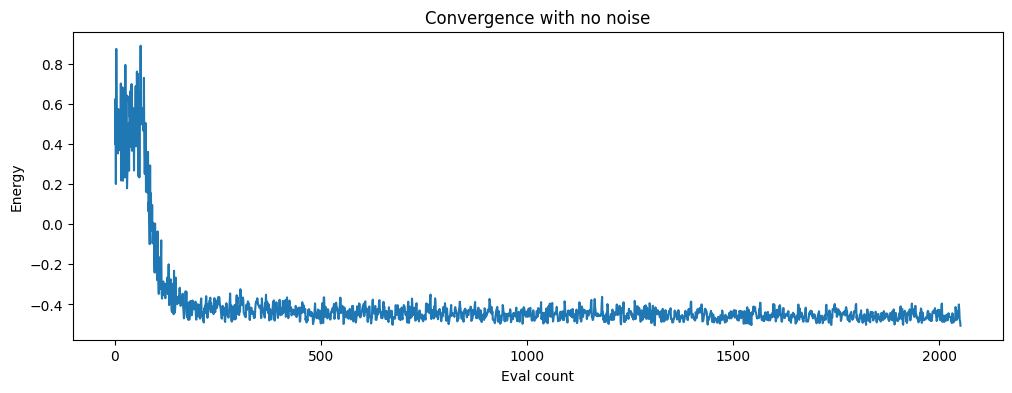

In [23]:
pylab.rcParams['figure.figsize'] = (12, 4)
pylab.plot(counts, values)
#plt.xlim(0,2000)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Convergence with no noise')

In [13]:
import os
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeVigo
device_backend = FakeVigo()

backend = Aer.get_backend('qasm_simulator')  # You can change it acccording to your calculations
counts1 = []
values1 = []
noise_model = None
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()

algorithm_globals.random_seed = seed
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,)

def store_intermediate_result1(eval_count, parameters, mean, std):
    counts1.append(eval_count)
    values1.append(mean)

#var_form = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(my_ansatz, optimizer=spsa, callback=store_intermediate_result1, quantum_instance=qi)
result1 = vqe.compute_minimum_eigenvalue(operator=qubit_op)
print(f'VQE on Aer qasm simulator (with noise): {result1.eigenvalue.real:.16f}')
print(f'Delta from reference energy value is {(result1.eigenvalue.real - ref_value):.16f}')

/tmp/ipykernel_143024/3706970262.py:4: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeVigo


NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'set_density_matrix', 'set_stabilizer', 'set_statevector', 'sx', 'x']
  Instructions with noise: ['id', 'cx', 'measure', 'x', 'sx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]



/tmp/ipykernel_143024/3706970262.py:20: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
/tmp/ipykernel_143024/3706970262.py:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result1, quantum_instance=qi)


VQE on Aer qasm simulator (with noise): 0.0797911558816226
Delta from reference energy value is 0.5780240666106928


In [14]:
import matplotlib.pyplot as plt

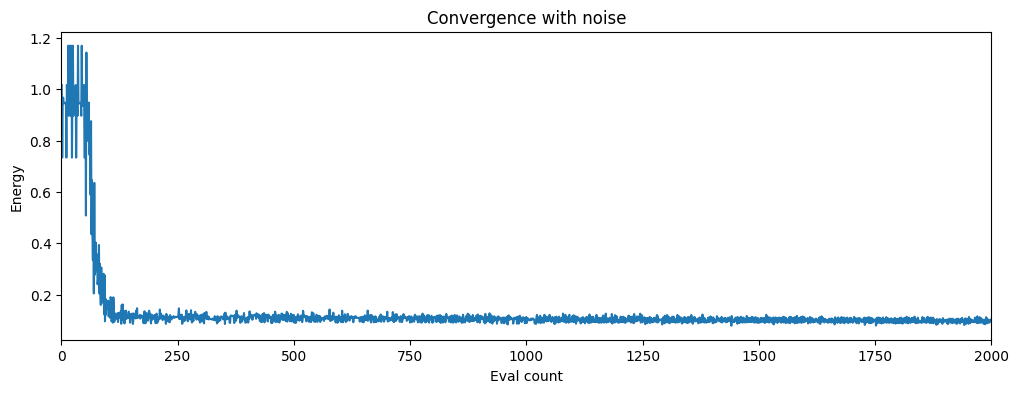

In [15]:
if counts1 or values1:
    pylab.rcParams['figure.figsize'] = (12, 4)
    plt.xlim(0,2000)
    pylab.plot(counts1, values1)
    pylab.xlabel('Eval count')
    pylab.ylabel('Energy')
    pylab.title('Convergence with noise')

In [16]:
from qiskit.utils.mitigation import CompleteMeasFitter

counts2 = []
values2 = []
if noise_model is not None:
    algorithm_globals.random_seed = seed
    qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                         coupling_map=coupling_map, noise_model=noise_model,
                         measurement_error_mitigation_cls=CompleteMeasFitter,
                         cals_matrix_refresh_period=30)

    def store_intermediate_result2(eval_count, parameters, mean, std):
        counts2.append(eval_count)
        values2.append(mean)

    ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
    spsa = SPSA(maxiter=iterations)
    vqe = VQE(my_ansatz, optimizer=spsa, callback=store_intermediate_result2, quantum_instance=qi)
    result2 = vqe.compute_minimum_eigenvalue(operator=qubit_op)
    print(f'VQE on Aer qasm simulator (with noise and measurement error mitigation): {result2.eigenvalue.real:.5f}')
    print(f'Delta from reference energy value is {(result2.eigenvalue.real - ref_value):.5f}')

/tmp/ipykernel_143024/2594855765.py:7: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
/tmp/ipykernel_143024/2594855765.py:18: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result2, quantum_instance=qi)


VQE on Aer qasm simulator (with noise and measurement error mitigation): -0.48695
Delta from reference energy value is 0.01128


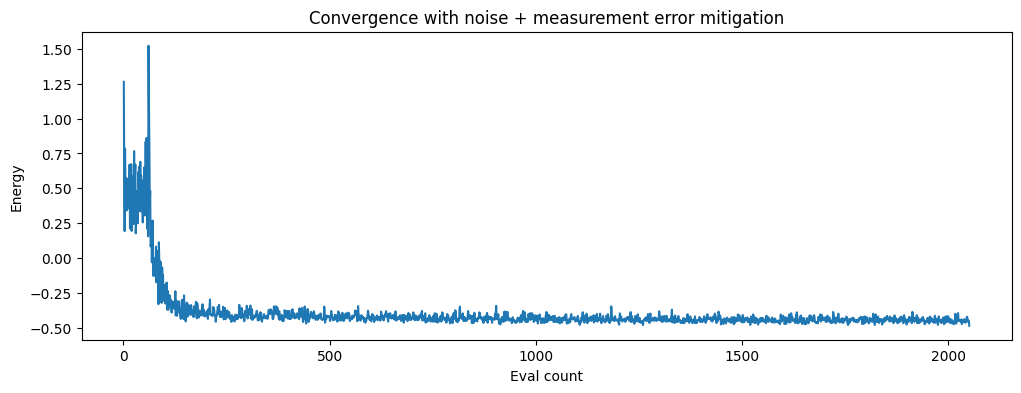

In [17]:
if counts2 or values2:
    pylab.rcParams['figure.figsize'] = (12, 4)
    pylab.plot(counts2, values2)
    pylab.xlabel('Eval count')
    pylab.ylabel('Energy')
    pylab.title('Convergence with noise + measurement error mitigation')

In [39]:
print(f'Reference value: {ref_value:.15f}')
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.15f}')
print(f'VQE on Aer qasm simulator (with noise): {result1.eigenvalue.real:.15f}')
print(f'VQE on Aer qasm simulator (with noise and measurement error mitigation): {result2.eigenvalue.real:.15f}')

Reference value: -0.498232910729071
VQE on Aer qasm simulator (no noise): -0.498232910729071
VQE on Aer qasm simulator (with noise): 0.079791155881623
VQE on Aer qasm simulator (with noise and measurement error mitigation): -0.486954666579837


In [40]:
def plot_graph(counts, values):
    
    plt.rcParams["font.size"] = 14

    # plot loss and reference value
    plt.figure(figsize=(12, 6), facecolor='white')
    plt.plot(values, label="Estimator VQE {}".format(molecule),color = color)
    #plt.axhline(y=, color="tab:red", ls="--", label="Target")

    plt.legend(loc="best")
    plt.xlabel("Iteration")
    plt.ylabel("Energy [H]")
    plt.title("VQE energy")
    plt.show()


-0.49823291072907105


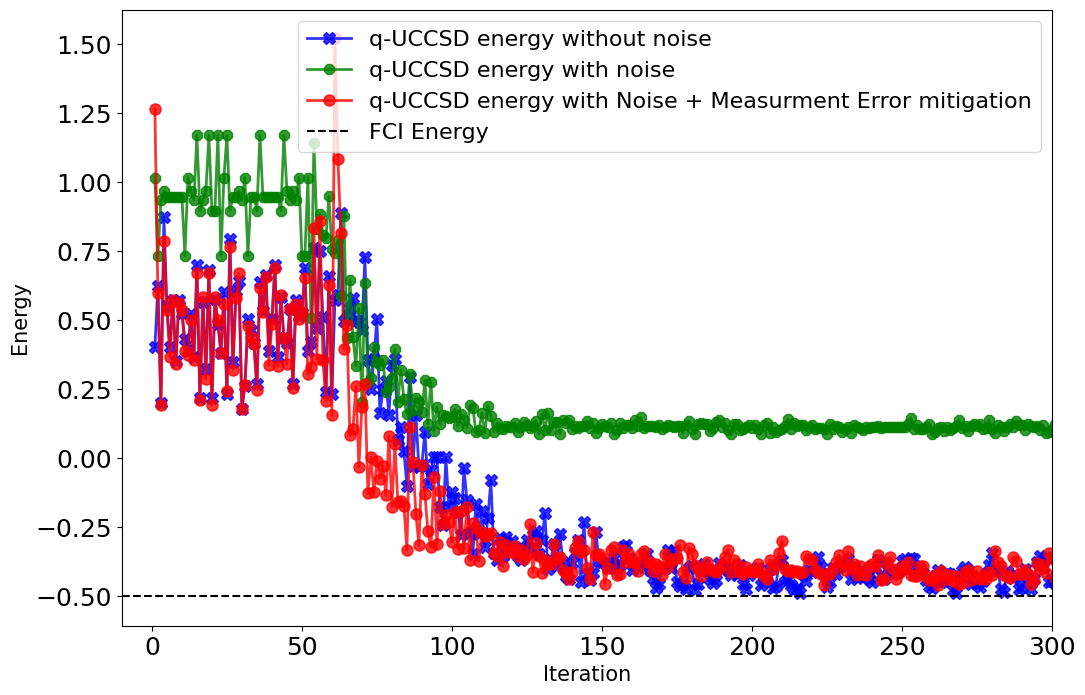

In [58]:

Reference=ref_value
print(Reference)

# plot loss and reference value
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8), facecolor='white')
pylab.plot(counts,values, color='b', marker='X', alpha=0.8,markersize=8,linewidth=2,label="q-UCCSD energy without noise")
pylab.plot(counts1,values1, color='g', marker='8', alpha=0.8,markersize=8,linewidth=2,label="q-UCCSD energy with noise")
pylab.plot(counts2,values2, color='r', marker='o', alpha=0.8,markersize=8,linewidth=2,label="q-UCCSD energy with Noise + Measurment Error mitigation")
pylab.axhline(y=Reference, color="black", ls="--", label="FCI Energy")

plt.xlim(-10,300)

plt.legend(loc="best",fontsize=16)
plt.xlabel("Iteration",fontsize=15)
plt.ylabel("Energy",fontsize=15)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
#plt.title("VQE + ZNE Energy")
plt.show()





In [64]:
# For ZNE You can modify the code using these format
from mitiq import zne # You can use the mitiq package mitiq pacakge has all the necessary things for the calculation, 
#you just have to put the ansatz in the code 
from functools import partial

from qiskit import Aer, IBMQ
from qiskit.utils import QuantumInstance
from qiskit.providers.aer.noise import NoiseModel
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.opflow import CircuitStateFn, StateFn, PauliExpectation, CircuitSampler
shots = 10000
backend = Aer.get_backend('qasm_simulator')
noise_model = NoiseModel.from_backend(provider.get_backend('ibmq_quito'))
measurement_error_mitigation_cls=CompleteMeasFitter
optimization_level = 0
quantuminstance = QuantumInstance(backend, 
                                  shots=shots,
                                  noise_model=noise_model,
                                  optimization_level=optimization_level,
                                  measurement_error_mitigation_cls=measurement_error_mitigation_cls)
scale_factors = [1.0, 2.0, 3.0, 3.5]

mitigated = zne.execute_with_zne(my_ansatz, get_expectation, 
                                 factory=zne.inference.RichardsonFactory(scale_factors=scale_factors),
                                 num_to_average=3,
                                 scale_noise=partial(zne.scaling.fold_gates_from_left))                        
not_mitigated = get_expectation(my_ansatz)

quantuminstance = QuantumInstance(Aer.get_backend('statevector_simulator'))
# print(mitigated, not_mitigated, exact)

In [71]:
#from mitq website you can learn about the implementation of the ZNE
# linear_factory = zne.inference.LinearFactory(scale_factors=[1.0, 1.5, 2.0, 2.5, 3.0])
# mitigated = zne.execute_with_zne(circuit, ibmq_executor, factory=linear_factory)
# print(f"Mitigated result {mitigated:.3f}")

In [65]:
# If you want to use the Prototype-ZNE module I have given the link to the repository in the reference
from zne import NOISE_AMPLIFIER_LIBRARY
NOISE_AMPLIFIER_LIBRARY.keys()
from zne.noise_amplification import GlobalFoldingAmplifier, LocalFoldingAmplifier
noise_amplifier = GlobalFoldingAmplifier()
cir = circuits[1]
display(cir.draw("mpl")))
obs = observables[0]
print(obs)
noise_factors = range(1,9)
list(noise_factors)
from zne.extrapolation import PolynomialExtrapolator
## ZNE STRATEGY
noise_amplifier = LocalFoldingAmplifier(
    gates_to_fold=2,
    sub_folding_option='from_first',
)
extrapolator = PolynomialExtrapolator(
    degree=2,
)
zne_strategy = ZNEStrategy(
    noise_factors=noise_factors,
    noise_amplifier=noise_amplifier,
    extrapolator=extrapolator,
)
## CALCULATION
estimator = ZNEEstimator(backend=Backend(), zne_strategy=zne_strategy)   
job = estimator.run(
    circuits=cir,
    observables=obs,
)
result = job.result()

In [66]:
# Example: depolarizing noise model, In place of the circuit, you can place the ansatz of your interest

In [67]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
import qiskit_aer.noise as noise
 
# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.01   # 2-qubit gate
 
# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)
 
# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
 
# Get basis gates from noise model
basis_gates = noise_model.basis_gates
 
# Make a circuit
circ = QuantumCircuit(3, 3)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.measure([0, 1, 2], [0, 1, 2])
 
# Perform a noise simulation
result = execute(circ, Aer.get_backend('qasm_simulator'),
                 basis_gates=basis_gates,
                 noise_model=noise_model).result()
counts = result.get_counts(0)
plot_histogram(counts)

In [68]:
## References

In [ ]:
https://quantumai.google/openfermion
https://pyscf.org/user/gto.html
https://docs.quantum.ibm.com/api/qiskit/0.45/qiskit.algorithms.minimum_eigensolvers.VQE
https://docs.quantum.ibm.com/api/qiskit/0.40/qiskit_aer.noise.depolarizing_error
https://github.com/qiskit-community/qiskit-nature/blob/main/test/second_q/algorithms/ground_state_solvers/test_advanced_ucc_variants.py
https://docs.quantum.ibm.com/guides/build-noise-models
https://github.com/qiskit-community/prototype-zne/tree/main/test
https://mitiq.readthedocs.io/en/stable/examples/quantum_simulation_scars_ibmq.html